<a href="https://colab.research.google.com/github/Adityavdwiv/DataAnalysisGroupProjects/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_url = "https://raw.githubusercontent.com/Adityavdwiv/DataAnalysisGroupProjects/main/diabetes.csv"
df = pd.read_csv(data_url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
cols_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

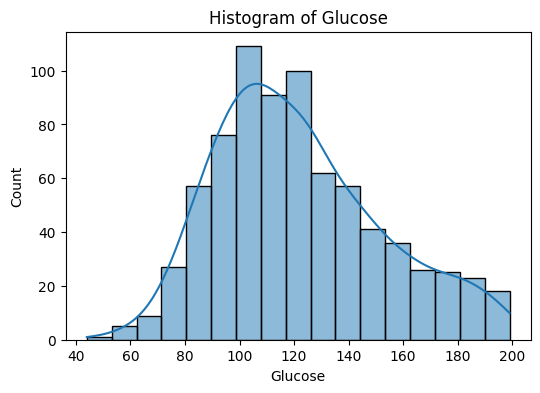

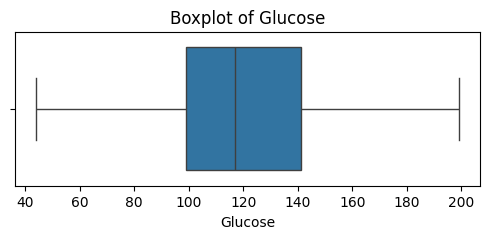

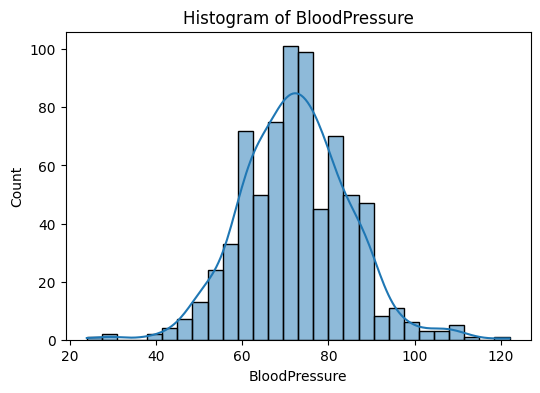

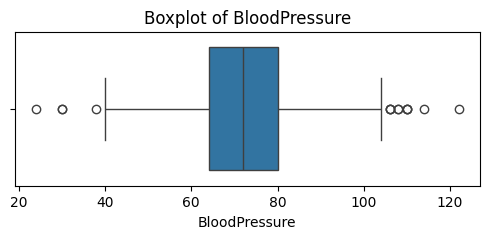

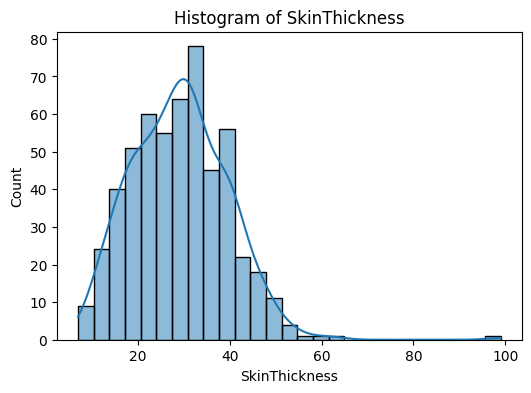

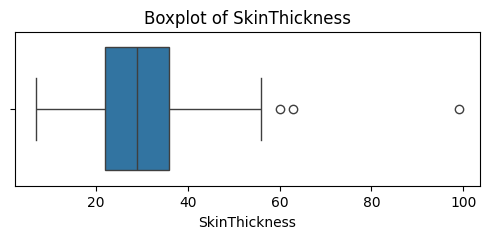

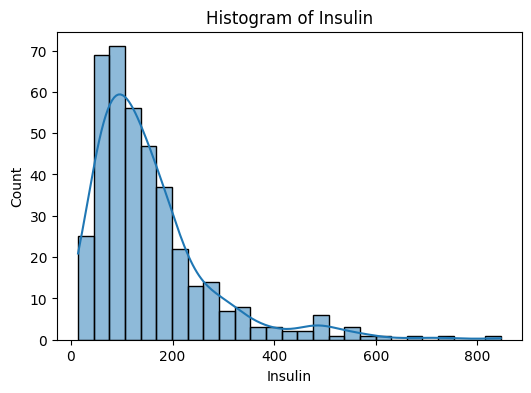

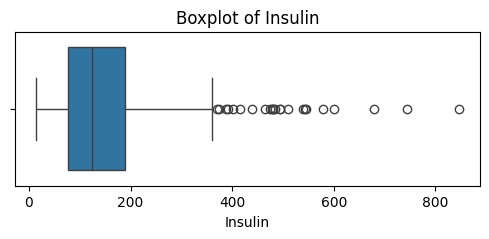

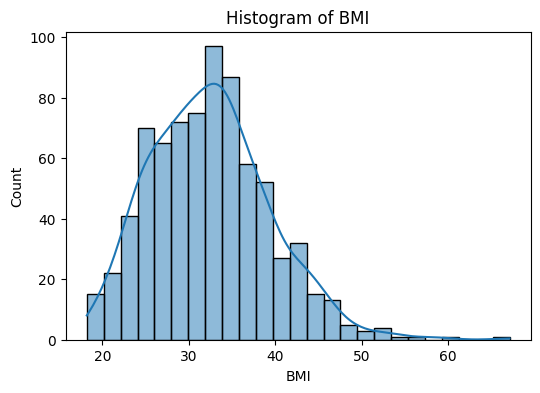

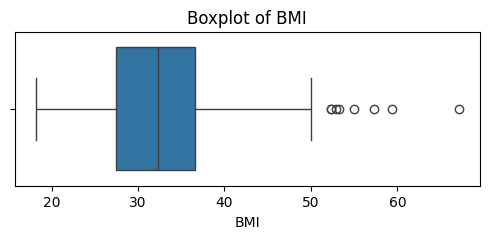

In [6]:
for col in cols_with_zero_invalid:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

<Axes: >

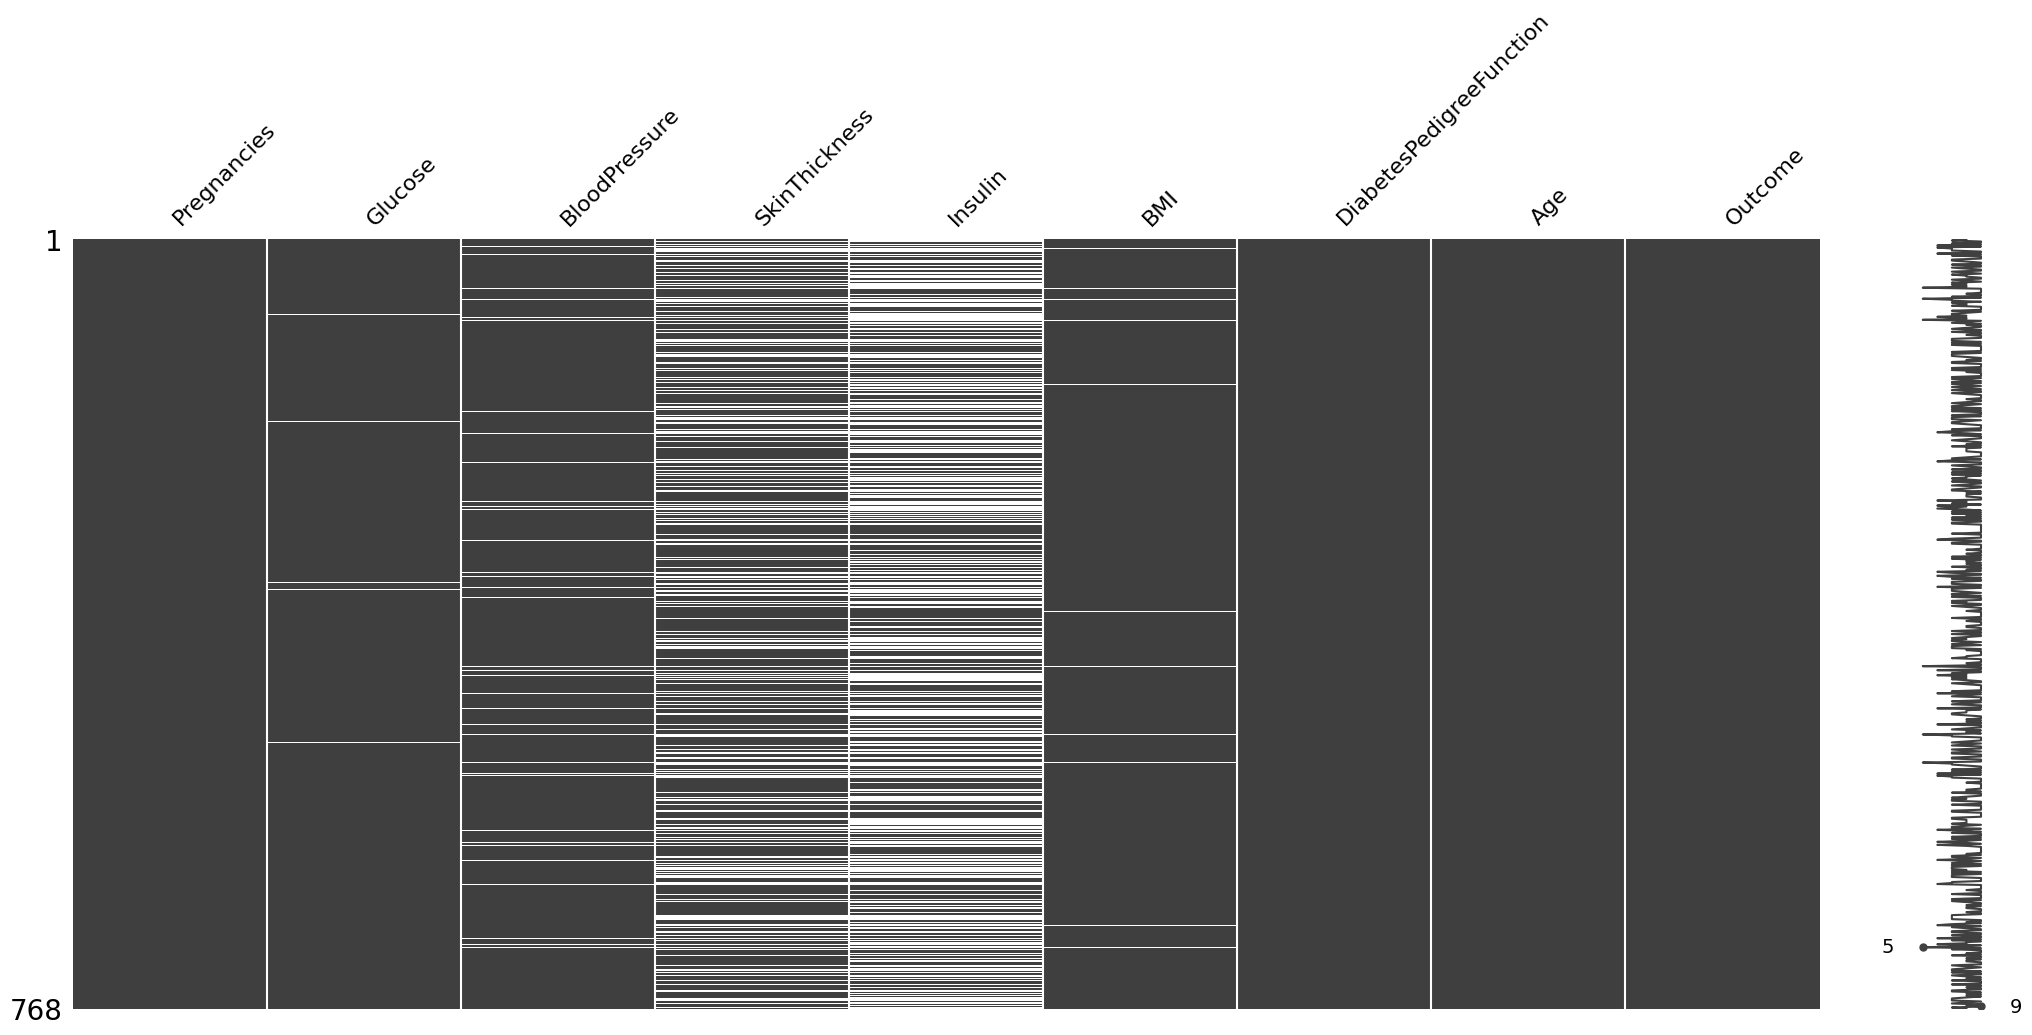

In [7]:
import missingno as msno
msno.matrix(df)

In [9]:
#Imputation (Mean, KNN, Iterative)

from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Needed to use IterativeImputer
from sklearn.impute import IterativeImputer

# Make a copy of the dataframe for each method
df_mean = df.copy()
df_knn = df.copy()
df_iter = df.copy()

# List of columns to impute
cols_with_na = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

### 1. Mean Imputation
for col in cols_with_na:
    df_mean[col].fillna(df_mean[col].mean(), inplace=True)

### 2. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[cols_with_na] = knn_imputer.fit_transform(df_knn[cols_with_na])

### 3. Iterative Imputation (MICE)
iter_imputer = IterativeImputer()
df_iter[cols_with_na] = iter_imputer.fit_transform(df_iter[cols_with_na])

/tmp/ipython-input-9-3218467508.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_mean[col].fillna(df_mean[col].mean(), inplace=True)


In [10]:
#Feature Engineering
df_fe = df_iter.copy()  # start with Iteratively Imputed Data

# 1. BMI Category
df_fe['BMI_cat'] = pd.cut(df_fe['BMI'],
                          bins=[0, 18.5, 25, 30, np.inf],
                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# 2. Age Group
df_fe['AgeGroup'] = pd.cut(df_fe['Age'],
                           bins=[20, 30, 40, 50, 60, 70, 100],
                           labels=['20s', '30s', '40s', '50s', '60s', '70+'])

# 3. High Glucose Flag
df_fe['HighGlucose'] = (df_fe['Glucose'] >= 140).astype(int)

# 4. Glucose × BMI Interaction
df_fe['Glucose_BMI'] = df_fe['Glucose'] * df_fe['BMI']

# Preview the new columns
df_fe[['BMI', 'BMI_cat', 'Age', 'AgeGroup', 'HighGlucose', 'Glucose_BMI']].head()

,BMI,BMI_cat,Age,AgeGroup,HighGlucose,Glucose_BMI
0,33.6,Obese,50,40s,1,4972.8
1,26.6,Overweight,31,30s,0,2261.0
2,23.3,Normal,32,30s,1,4263.9
3,28.1,Overweight,21,20s,0,2500.9
4,43.1,Obese,33,30s,0,5904.7


In [11]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df_fe['BMI_cat'], df_fe['Outcome'])
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square statistic = {chi2:.4f}")
print(f"p-value = {p:.4e}")

Chi-square statistic = 74.4504
p-value = 4.7522e-16


In [12]:
import statsmodels.api as sm

# Define numeric features
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Add constant column (intercept)
X = sm.add_constant(df_fe[features])
y = df_fe['Outcome']

# Fit logistic regression
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.463624
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.2832
Time:                        23:50:07   Log-Likelihood:                -356.06
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 3.802e-56
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -9.1868      0.838    -10.958      0.000     -10.830

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,const,57.553368
1,Pregnancies,1.433108
2,Glucose,2.096564
3,BloodPressure,1.261403
4,SkinThickness,2.070403
5,Insulin,2.036511
6,BMI,2.205494
7,DiabetesPedigreeFunction,1.045212
8,Age,1.613135


# Baseline Logistic Regression Model

For this baseline model, we selected key features known to be relevant for predicting diabetes, including Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, Diabetes Pedigree Function, and Age. The dataset was split into training and testing sets using an 80/20 ratio, with stratification applied to maintain the original class distribution in both sets. To prepare the data for modeling, we standardized the features using StandardScalar, which helps improve model convergence by normalizing the feature ranges.

We then trained a Logistic Regression model with default parameters and increased the maximum number of iterations to 1000 to ensure proper convergence. Predictions were made on the test set, with the first 10 predicted class labels shown as `[1 0 0 0 0 0 0 1 0 1]`. This baseline setup lays the groundwork for further evaluation and comparison with other imputation methods, feature engineering, and techniques to handle class imbalance.

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Features and target
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X = df_fe[features]
y = df_fe['Outcome']

In [76]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [94]:
# Train baseline logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Predict class labels
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # For ROC
print("Predicted classification vector:", y_pred[:10])

Predicted classification vector: [1 0 0 0 0 0 0 1 0 1]


# Custom Evaluation Metrics and Comparison

We generated a confusion matrix from the baseline logistic regression predictions to obtain the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). Using these values, we implemented custom functions to calculate key performance metrics: Accuracy, Precision, Recall (Sensitivity), Specificity, and F1 Scores.

For validation, we compared these custom-calculated metrics against those computed using the standard sklearn.metrics functions, which showed close agreement. This comparison confirms the correctness of our metric implementations and strengthens confidence in evaluating model performance moving forward.

In [78]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

TP: 27, FP: 19, TN: 81, FN: 27


In [79]:
def accuracy_score_custom(tp, fp, tn, fn):
    return (tp + tn) / (tp + tn + fp + fn)

def precision_score_custom(tp, fp):
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall_score_custom(tp, fn):
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def specificity_score_custom(tn, fp):
    return tn / (tn + fp) if (tn + fp) != 0 else 0

def f1_score_custom(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [80]:
accuracy = accuracy_score_custom(tp, fp, tn, fn)
precision = precision_score_custom(tp, fp)
recall = recall_score_custom(tp, fn)
specificity = specificity_score_custom(tn, fp)
f1 = f1_score_custom(precision, recall)

print(f"Custom Accuracy: {accuracy:.4f}")
print(f"Custom Precision: {precision:.4f}")
print(f"Custom Recall (Sensitivity): {recall:.4f}")
print(f"Custom Specificity: {specificity:.4f}")
print(f"Custom F1 Score: {f1:.4f}")

Custom Accuracy: 0.7013
Custom Precision: 0.5870
Custom Recall (Sensitivity): 0.5000
Custom Specificity: 0.8100
Custom F1 Score: 0.5400


In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n--- Comparison with sklearn.metrics ---")
print(f"sklearn Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"sklearn Precision: {precision_score(y_test, y_pred):.4f}")
print(f"sklearn Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"sklearn F1 Score:  {f1_score(y_test, y_pred):.4f}")


--- Comparison with sklearn.metrics ---
sklearn Accuracy:  0.7013
sklearn Precision: 0.5870
sklearn Recall:    0.5000
sklearn F1 Score:  0.5400


# Hyperparameter Tuning with GridSearchCV

To improve the baseline logistic regression model, we applied hyperparameter tuning using GridSearchCV with 5-fold cross-validation. The parameter grid included different regularization strengths (C), penalty types (l1 and l2), solver set to liblinear (which supports both penalties), and options for class weighting (None or 'balanced'). The scoring metric for optimization was the F1 score, balancing precision and recall.

After fitting the grid search on the training data, the best parameter combination was identified, and the corresponding tuned model was saved. Predictions on the test set were generated using this tuned model. The confusion matrix and custom evaluation metrics were computed, showing improved performance compared to the baseline.

We also validated the custom metrics against sklearn.metrics functions, confirming consistent results. This hyperparameter tuning step helped enhance the model’s ability to detect diabetes while managing false positives effectively.

| Metric          | Baseline | Tuned Model | Change |
|-----------------|----------|-------------|--------|
| Accuracy        | 0.7013   | 0.7338      | ↑ +0.0325 |
| Precision       | 0.5870   | 0.6032      | ↑ +0.0162 |
| Recall          | 0.5000   | 0.7037      | ↑ +0.2037 |
| Specificity     | 0.8100   | 0.7500      | ↓ -0.0600 |
| F1 Score        | 0.5400   | 0.6496      | ↑ +0.1096 |

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear supports l1 and l2
    'class_weight': [None, 'balanced']
}

logreg = LogisticRegression(max_iter=1000)

grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)

# Save the best model
best_logreg = grid.best_estimator_

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [83]:
# Predict class labels and probabilities with tuned model
y_pred_tuned = best_logreg.predict(X_test_scaled)
y_pred_proba_tuned = best_logreg.predict_proba(X_test_scaled)[:, 1]

In [84]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
print(f"Tuned Model - TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

Tuned Model - TP: 38, FP: 25, TN: 75, FN: 16


In [85]:
# Use previously defined custom metric functions
accuracy = accuracy_score_custom(tp, fp, tn, fn)
precision = precision_score_custom(tp, fp)
recall = recall_score_custom(tp, fn)
specificity = specificity_score_custom(tn, fp)
f1 = f1_score_custom(precision, recall)

print(f"TUNED MODEL Custom Accuracy: {accuracy:.4f}")
print(f"TUNED MODEL Custom Precision: {precision:.4f}")
print(f"TUNED MODEL Custom Recall: {recall:.4f}")
print(f"TUNED MODEL Custom Specificity: {specificity:.4f}")
print(f"TUNED MODEL Custom F1 Score: {f1:.4f}")


TUNED MODEL Custom Accuracy: 0.7338
TUNED MODEL Custom Precision: 0.6032
TUNED MODEL Custom Recall: 0.7037
TUNED MODEL Custom Specificity: 0.7500
TUNED MODEL Custom F1 Score: 0.6496


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n--- TUNED MODEL sklearn.metrics ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_tuned):.4f}")


--- TUNED MODEL sklearn.metrics ---
Accuracy:  0.7338
Precision: 0.6032
Recall:    0.7037
F1 Score:  0.6496


# Class Imbalance with Class Weights and SMOTE

We began by examining the class distribution in the dataset, confirming the imbalance in the outcome variable. A crosstab analysis between BMI categories and diabetes outcomes was also performed to explore potential relationships between these variables.

To mitigate the impact of class imbalance on model performance, we applied two techniques: Logistic Regression with class weighting (class_weight='balanced') and SMOTE. SMOTE was used to generate synthetic samples of the minority class but only on the training data to prevent data leakage.

Both models were trained accordingly — one on the original training set with balanced class weights and the other on the SMOTE-resampled training set. Their performance was then evaluated on the test set using custom metrics for accuracy, precision, recall, specificity, and F1 score. It helped demonstrate how imbalance handling techniques affect the model’s ability to correctly identify diabetes cases while controlling false positives.

| Metric       | LogReg with Class Weights | LogReg on SMOTE Data |
|--------------|---------------------------|----------------------|
| Accuracy     | 0.7338                    | 0.7208               |
| Precision    | 0.6032                    | 0.5932               |
| Recall       | 0.7037                    | 0.6481               |
| Specificity  | 0.7500                    | 0.7600               |
| F1 Score     | 0.6496                    | 0.6195               |

In [87]:
print("Outcome value counts:")
print(df_fe['Outcome'].value_counts())

# Crosstab: Outcome vs BMI Category
print("\nCrosstab of Outcome by BMI Category:")
print(pd.crosstab(df_fe['BMI_cat'], df_fe['Outcome']))

Outcome value counts:
Outcome
0    500
1    268
Name: count, dtype: int64

Crosstab of Outcome by BMI Category:
Outcome        0    1
BMI_cat              
Underweight    4    0
Normal       101    7
Overweight   138   44
Obese        257  217


In [93]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample training data only
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set shape: {X_train_scaled.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_resampled.shape}, {y_resampled.shape}")

Original training set shape: (614, 8), (614,)
Resampled training set shape: (800, 8), (800,)


In [89]:
logreg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = logreg_balanced.predict(X_test_scaled)

logreg_smote = LogisticRegression(max_iter=1000)
logreg_smote.fit(X_resampled, y_resampled)

y_pred_smote = logreg_smote.predict(X_test_scaled)

In [90]:
from sklearn.metrics import confusion_matrix

def evaluate_model(y_true, y_pred, label="Model"):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score_custom(tp, fp, tn, fn)
    precision = precision_score_custom(tp, fp)
    recall = recall_score_custom(tp, fn)
    specificity = specificity_score_custom(tn, fp)
    f1 = f1_score_custom(precision, recall)

    print(f"--- {label} ---")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score:    {f1:.4f}")
    print()

# Evaluate both models
evaluate_model(y_test, y_pred_balanced, "LogReg with Class Weights")
evaluate_model(y_test, y_pred_smote, "LogReg on SMOTE Data")

--- LogReg with Class Weights ---
Accuracy:    0.7338
Precision:   0.6032
Recall:      0.7037
Specificity: 0.7500
F1 Score:    0.6496

--- LogReg on SMOTE Data ---
Accuracy:    0.7208
Precision:   0.5932
Recall:      0.6481
Specificity: 0.7600
F1 Score:    0.6195



# Confusion Matrices and ROC-AUC Curve Comparison

To visually compare the classification performance of our models, we plotted confusion matrices side-by-side for the baseline logistic regression, logistic regression with class weights, and logistic regression trained on SMOTE-resampled data.

Additionally, ROC curves were generated for all three models on the test set, allowing us to assess the trade-off between sensitivity and specificity across different classification thresholds. The area under the ROC curve (AUC) scores were also calculated and printed, providing a numerical summary of each model’s ability to differentiate between positive and negative classes.

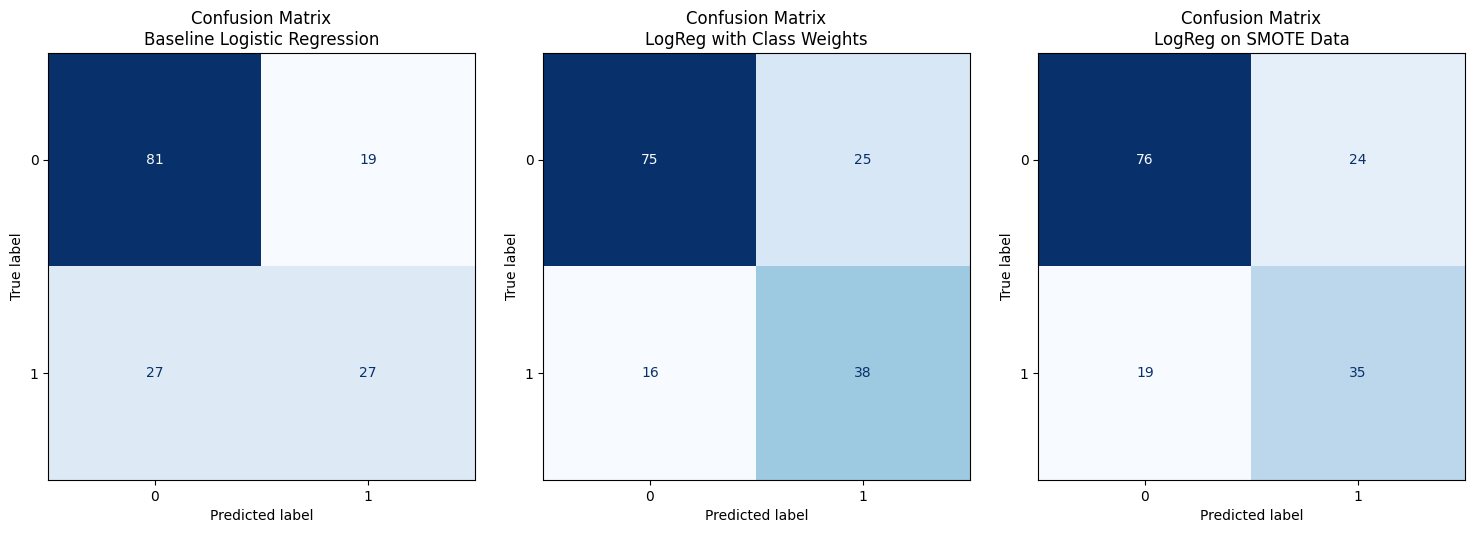

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrices(models, X_test, y_test):
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
    for ax, (name, model) in zip(axes, models):
        y_pred = model.predict(X_test)
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, ax=ax, cmap='Blues', colorbar=False
        )
        ax.set_title(f'Confusion Matrix\n{name}')
    plt.tight_layout()
    plt.show()

models_to_plot = [
    ("Baseline Logistic Regression", logreg),
    ("LogReg with Class Weights", logreg_balanced),
    ("LogReg on SMOTE Data", logreg_smote)
]

plot_confusion_matrices(models_to_plot, X_test_scaled, y_test)


<Figure size 800x600 with 0 Axes>

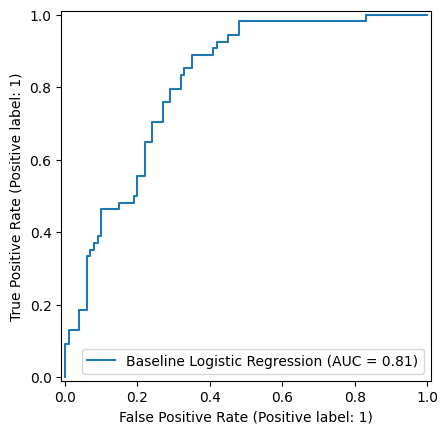

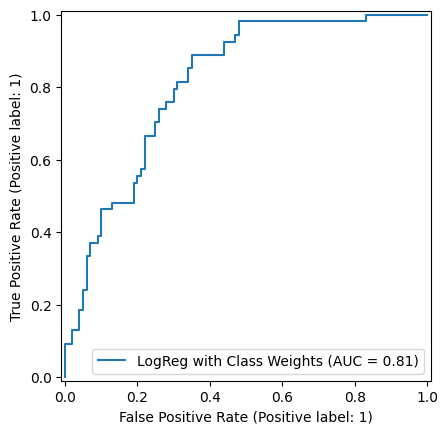

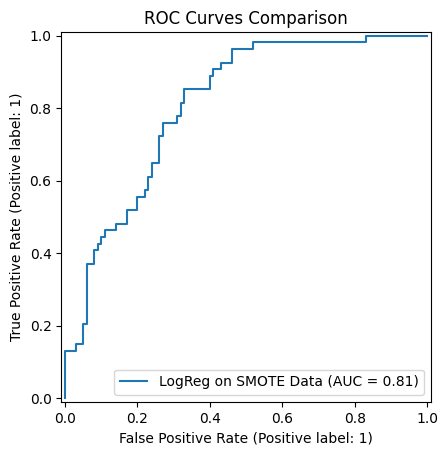

Baseline Logistic Regression AUC: 0.8120
LogReg with Class Weights AUC: 0.8115
LogReg on SMOTE Data AUC: 0.8089


In [96]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    for name, model in models:
        y_proba = model.predict_proba(X_test)[:, 1]
        RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
    plt.title('ROC Curves Comparison')
    plt.show()

models_to_plot = [
    ("Baseline Logistic Regression", logreg),
    ("LogReg with Class Weights", logreg_balanced),
    ("LogReg on SMOTE Data", logreg_smote)
]

plot_roc_curves(models_to_plot, X_test_scaled, y_test)

for name, model in models_to_plot:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"{name} AUC: {auc:.4f}")